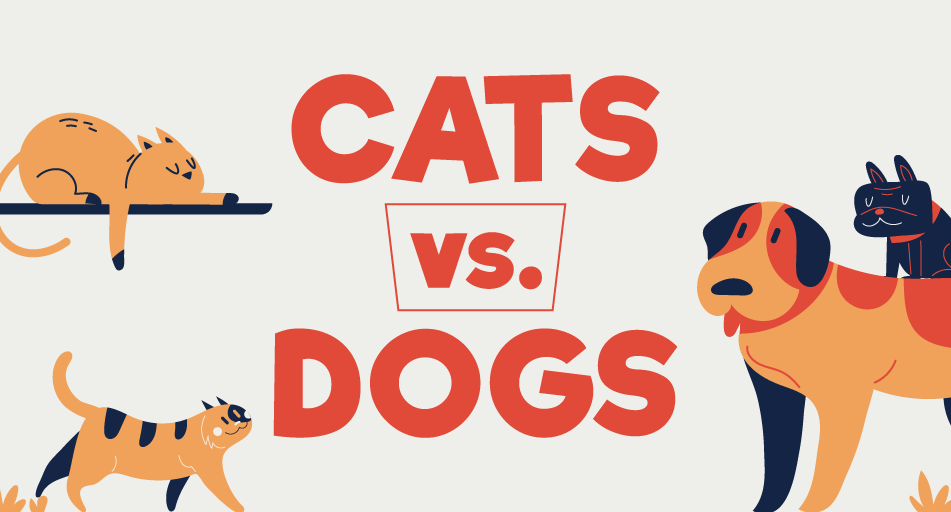

In [32]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import cv2

# Models
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Data Splitting
from sklearn.model_selection import train_test_split

# Scailing
from sklearn.preprocessing import StandardScaler

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

Before we start with data visualization and modelling, we will create from the images we have the data frame that we will work with.<br>
<br>
To this end, we will define new functions that will help us read the images, resize them, change their colors to grayscale, and adjust them to the correct label of a dog or a cat.<br>
<br>
Using OpenCV library we'll read the images by their file path, resize them (to 64 by 64), and change their colors to grayscale.<br>
These operations will be performed in the following function.

In [3]:
def readImg_convert2gray_resize(file_path):
    img = cv2.imread(file_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray_img, (64,64))
    return resized_img

The next function will run on all the pictures of the cats and all the pictures of the dogs and use the previous function to arrange the pictures correctly in an array and add the corresponding label value to a separate array.

In [4]:
def img2array_addLabel(name, label):    
    numberOfImages=12500
    imgSize = 64*64
    X = np.ndarray((numberOfImages,imgSize), dtype=np.uint8)
    y = np.zeros((numberOfImages,1))
    folder = 'C:/Users/97254/Desktop/dogsVScats_train/train/'
    for i in range(numberOfImages):
        img = readImg_convert2gray_resize(folder + name + '.' + str(i) + '.jpg')
        X[i,:] = np.squeeze(img.reshape((imgSize,1)))
        y[i,0] = label
    return X,y

Once we have defined the new functions we can use them to load our data and turn it into a data frame that we can work with.

# Data Loading

### CATS

In [5]:
X1,y1 = img2array_addLabel('cat',0)
cat_df = pd.DataFrame(X1)
cat_df.shape

(12500, 4096)

In [6]:
cat_df['label'] = y1 # adding a column that expresses the label

### DOGS

In [7]:
X2,y2 = img2array_addLabel('dog',1)
dog_df = pd.DataFrame(X2)
dog_df.shape

(12500, 4096)

In [8]:
dog_df['label'] = y2 # adding a column that expresses the label

### MERGE DATA FRAMES

In [9]:
df = pd.concat([cat_df, dog_df])
df.shape

(25000, 4097)

As we can guess, our data frame is sorted by the label.<br>
Our next step is to mix all rows of our data frame before starting modelling.

In [10]:
df = df.sample(frac=1).reset_index(drop=True)
df

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,label
0,213,95,91,65,39,37,35,32,29,55,...,79,41,42,53,72,82,74,18,66,1.0
1,1,1,3,2,2,2,1,2,1,1,...,1,1,1,1,1,1,1,1,1,1.0
2,58,44,67,84,93,77,60,56,51,46,...,62,66,68,73,78,79,75,72,68,0.0
3,87,28,2,2,2,133,116,92,106,130,...,3,5,1,1,1,1,2,2,4,1.0
4,51,54,57,56,58,61,61,64,63,65,...,138,138,140,135,121,122,121,109,43,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,38,41,41,41,41,43,45,46,45,47,...,161,145,144,144,142,146,149,146,149,1.0
24996,38,36,125,116,116,110,116,124,118,119,...,40,36,37,34,34,28,29,29,27,0.0
24997,41,47,57,60,65,59,52,46,39,33,...,82,74,72,75,76,79,87,96,108,1.0
24998,109,103,101,102,102,99,102,103,104,107,...,80,80,81,116,154,159,159,155,157,1.0


### Split into Final Test Set and Final Train Set

The data is adjusted only on the train set, so we have to split the data into train set and test set.<br>We will not touch the test set at all, while we will use the train set to decide which model will be the best.

In [11]:
FinalTest = df.iloc[:3570, :].reset_index(drop=True)
FinalTrain = df.iloc[3570:, :].reset_index(drop=True)

In [12]:
FinalTrain.shape

(21430, 4097)

In [13]:
FinalTest.shape

(3570, 4097)

We will check that the data is well divided between the test set and the train set.<br>
<br>
First we can see according to the next pie that we have the same amount of cats and dogs in our data frame.

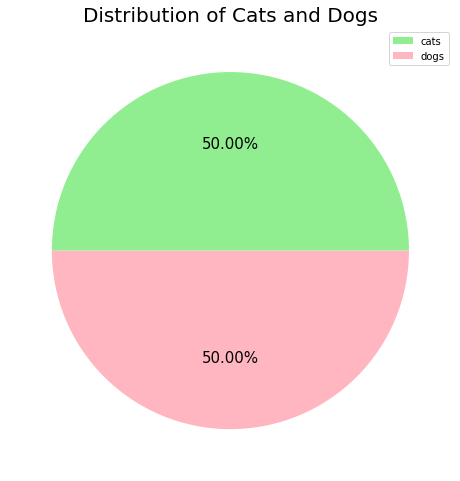

In [14]:
label = ['cats', 'dogs']

sorted_df = df.sort_values(by=['label'])
plt.subplots(figsize=(8, 9))
plt.pie(sorted_df['label'].value_counts(), colors = ['lightgreen', 'lightpink'], autopct = '%.2f%%' , textprops={"fontsize":15})
plt.title('Distribution of Cats and Dogs' , fontdict = {'fontsize' : 20})
plt.legend(label , loc=1)

plt.show()

Next, according to the two next pies we can see that also the final sets are well divided.

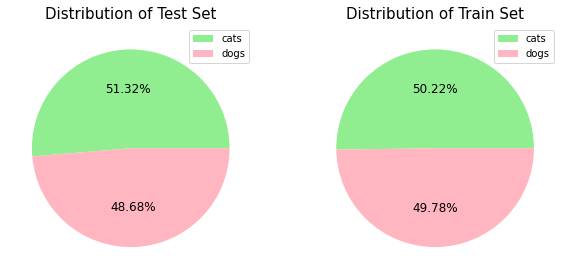

In [15]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
sorted_test = FinalTest.sort_values(by=['label'])
plt.pie(sorted_test['label'].value_counts(), colors = ['lightgreen', 'lightpink'], autopct = '%.2f%%' , textprops={"fontsize":12})
plt.title('Distribution of Test Set' , fontdict = {'fontsize' : 15})
plt.legend(label , loc=1)

plt.subplot(2,2,2)
sorted_train = FinalTrain.sort_values(by=['label'])
plt.pie(sorted_train['label'].value_counts(), colors = ['lightgreen', 'lightpink'], autopct = '%.2f%%' , textprops={"fontsize":12})
plt.title('Distribution of Train Set' , fontdict = {'fontsize' : 15})
plt.legend(label , loc=1)

plt.show()

After we saw that the data is organized, we can split the final train set into another train and test sets that we can work with, untill we will find our best model.

# Visualization of Data

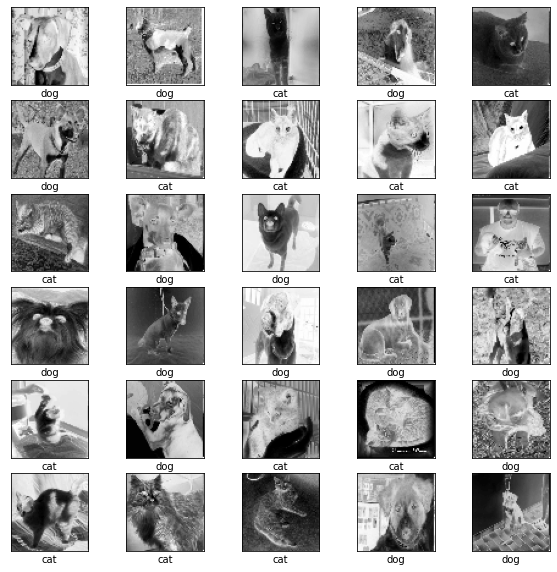

In [16]:
# Meaning of each label
label = ['cat', 'dog']

# Scailing by dividing all in 255
input_data = df.iloc[:,1:] / 255
target = df[['label']].iloc[:, :]
# Set the figure size
plt.figure(figsize=(10,10))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(input_data.iloc[i, :]).reshape(64,64), cmap=plt.cm.binary)
    plt.xlabel(label[int(target.label.iloc[i])])

In [17]:
X = FinalTrain.drop('label', axis=1)
y = FinalTrain.label


# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=4)

In [18]:
X_train.shape

(17786, 4096)

In [19]:
X_test.shape

(3644, 4096)

# PCA

During the semester we learned about the importance of dimensionality reduction.<br> We will now try to see this importance and then we will use dimensionality reduction.<br>
<br>
Let's see how dimensionality reductiot is expressed in the images themselves.

In [20]:
pca = PCA(n_components=16)
X_reduced = pca.fit_transform(X_train)

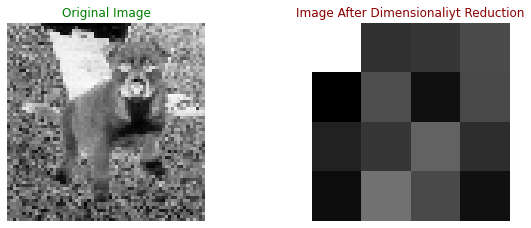

In [25]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(X_train.to_numpy()[2246].reshape(64,64) , cmap="gist_yarg")
plt.title("Original Image" , color="green")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(X_reduced[2245].reshape(4,4) , cmap="gist_yarg")
plt.title("Image After Dimensionaliyt Reduction" , color="darkred")
plt.axis("off")
plt.show()

We will try to find the lowest value for which we can identify as many labels as we want.

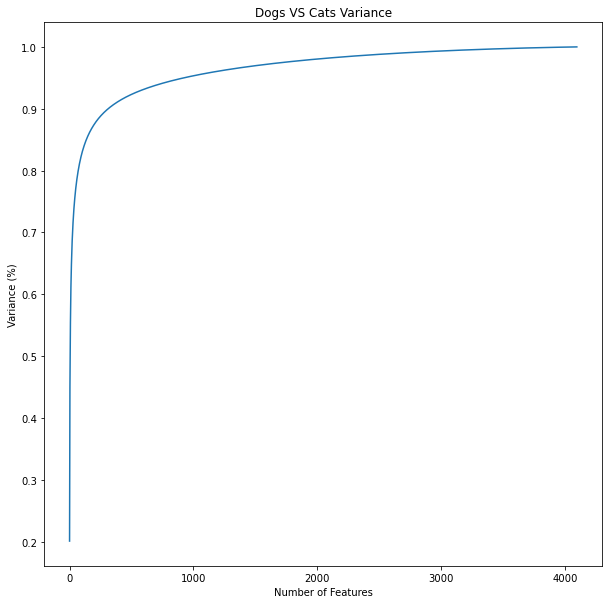

In [26]:
# fit the PCA with the training data
pca = PCA().fit(X_train)

# Plot the cumulative sum of eigenvalues
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Features')
plt.ylabel('Variance (%)') #for each component
plt.title('Dogs VS Cats Variance')
plt.show()

We'll check only untill 250 because the accuracy is high enough for us.<br>
We'll use PIPELINE to evaluate the score of each model.<br>
Before starting we'll try to find the amount of features by using Random Forest Classifier.

In [27]:
def PiplineScore(model , nComponents):
    pipeline_model = Pipeline([('scaler', StandardScaler()),
                               ('pca' , PCA(n_components=nComponents)),
                               ('model' , model())])

    pipeline_model.fit(X_train, y_train)
    print(model() , "Accuracy :  " , pipeline_model.score(X_test, y_test))
    return pipeline_model.score(X_test, y_test)

In [28]:
k_range = list(range(1,270,20))
scores = []
for k in k_range:
    score = PiplineScore(RandomForestClassifier , k)
    scores.append(score)

RandomForestClassifier() Accuracy :   0.5134467618002195
RandomForestClassifier() Accuracy :   0.6446212952799122
RandomForestClassifier() Accuracy :   0.6289791437980241
RandomForestClassifier() Accuracy :   0.6212952799121844
RandomForestClassifier() Accuracy :   0.6070252469813392
RandomForestClassifier() Accuracy :   0.6240395170142701
RandomForestClassifier() Accuracy :   0.6163556531284303
RandomForestClassifier() Accuracy :   0.6180021953896817
RandomForestClassifier() Accuracy :   0.6237650933040615
RandomForestClassifier() Accuracy :   0.6196487376509331
RandomForestClassifier() Accuracy :   0.6119648737650933
RandomForestClassifier() Accuracy :   0.6182766190998902
RandomForestClassifier() Accuracy :   0.6160812294182217
RandomForestClassifier() Accuracy :   0.6169045005488474


Text(0.5, 1.0, 'Random Forest Classifier')

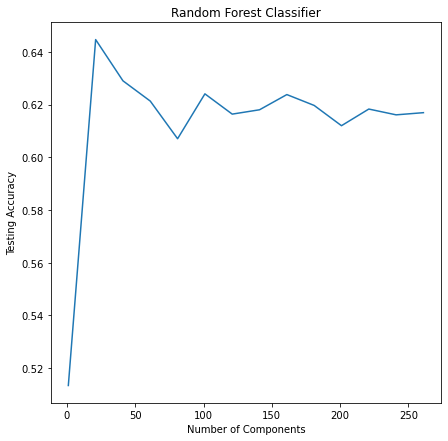

In [29]:
plt.figure(figsize=(7,7))
plt.plot(k_range, scores)
plt.xlabel('Number of Components')
plt.ylabel('Testing Accuracy')
plt.title('Random Forest Classifier')

We can understand that between 0 to 25 is the most change in accuracy.<br>
We'll look for the most lowest number of components that still gives us an acceptable accuracy.

In [30]:
k_range = list(range(1,25))
scores_0_25 = []
for k in k_range:
    score = PiplineScore(RandomForestClassifier , k)
    scores_0_25.append(score)

RandomForestClassifier() Accuracy :   0.5134467618002195
RandomForestClassifier() Accuracy :   0.5477497255762898
RandomForestClassifier() Accuracy :   0.5548847420417125
RandomForestClassifier() Accuracy :   0.5754665203073546
RandomForestClassifier() Accuracy :   0.5809549945115258
RandomForestClassifier() Accuracy :   0.5916575192096597
RandomForestClassifier() Accuracy :   0.6125137211855104
RandomForestClassifier() Accuracy :   0.6133369923161361
RandomForestClassifier() Accuracy :   0.6078485181119648
RandomForestClassifier() Accuracy :   0.6243139407244785
RandomForestClassifier() Accuracy :   0.6240395170142701
RandomForestClassifier() Accuracy :   0.6180021953896817
RandomForestClassifier() Accuracy :   0.6289791437980241
RandomForestClassifier() Accuracy :   0.6254116355653129
RandomForestClassifier() Accuracy :   0.6341931942919868
RandomForestClassifier() Accuracy :   0.6317233809001098
RandomForestClassifier() Accuracy :   0.6429747530186608
RandomForestClassifier() Accura

Text(0.5, 1.0, 'Random Forest Classifier')

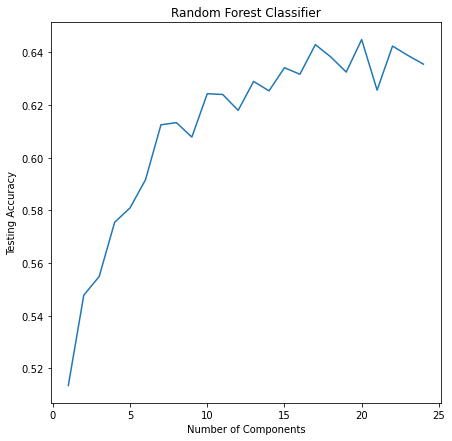

In [31]:
plt.figure(figsize=(7,7))
plt.plot(k_range, scores_0_25)
plt.xlabel('Number of Components')
plt.ylabel('Testing Accuracy')
plt.title('Random Forest Classifier')

As we can see 17 has an acceptable accuracy,<br>but we'll prefer 15 features in which the accuracy will be 63.4% than 17 features in which the accuracy is 64.2%.<br>
And so we will choose 15 as our n_components number.

In [36]:
def PiplineScore15(model):
    pipeline_model = Pipeline([('scaler', StandardScaler()),
                               ('pca' , PCA(n_components=15)),
                               ('model' , model)])

    pipeline_model.fit(X_train, y_train)
    print(model , "Accuracy :  " , pipeline_model.score(X_test, y_test))
    return pipeline_model.score(X_test, y_test)

### KNN k Value

For KNN model we'll look for the best k value.

KNeighborsClassifier(n_neighbors=1) Accuracy :   0.5559824368825467
KNeighborsClassifier(n_neighbors=3) Accuracy :   0.5831503841931943
KNeighborsClassifier() Accuracy :   0.5924807903402854
KNeighborsClassifier(n_neighbors=7) Accuracy :   0.602085620197585
KNeighborsClassifier(n_neighbors=9) Accuracy :   0.6009879253567508
KNeighborsClassifier(n_neighbors=11) Accuracy :   0.5974204171240395
KNeighborsClassifier(n_neighbors=13) Accuracy :   0.5998902305159166
KNeighborsClassifier(n_neighbors=15) Accuracy :   0.606476399560922
KNeighborsClassifier(n_neighbors=17) Accuracy :   0.6042810098792536
KNeighborsClassifier(n_neighbors=19) Accuracy :   0.6053787047200878


Text(0, 0.5, 'Testing Accuracy')

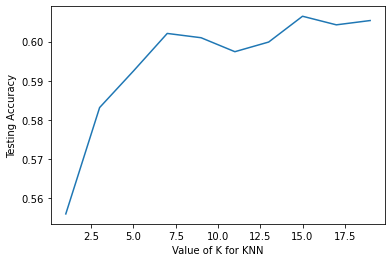

In [37]:
k_range = list(range(1, 20, 2))
scores = []
for k in k_range:
    score = PiplineScore15(KNeighborsClassifier(n_neighbors=k))
    scores.append(score)
     
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

We'll choose k=15 so we'll get the most high value of accuracy.

In [38]:
def PiplineScore15(model):
    pipeline_model = Pipeline([('scaler', StandardScaler()),
                               ('pca' , PCA(n_components=15)),
                               ('model' , model)])
    
    
    pipeline_model.fit(X_train, y_train)
    #model prediction
    y_pred = pipeline_model.predict(X_test)
    sns.set(font_scale=1.3)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=True , cmap="YlGnBu" , fmt = '.0f')
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    # evaluating the model
    print("Training Accuracy :", pipeline_model.score(X_train, y_train))
    print("Testing Accuracy :" , metrics.accuracy_score(y_test, y_pred))
    print()
    print(classification_report(y_test, y_pred))
    return pipeline_model.score(X_test , y_test)

# Modelling

In [79]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X, y)
dummy.score(X, y)

0.5021931871208586

We want to manage more than the dummy classifier score which is 50%.

Decision Tree Classifier:

Training Accuracy : 0.9992128640503767
Testing Accuracy : 0.5546103183315039

              precision    recall  f1-score   support

         0.0       0.56      0.55      0.55      1824
         1.0       0.55      0.56      0.56      1820

    accuracy                           0.55      3644
   macro avg       0.55      0.55      0.55      3644
weighted avg       0.55      0.55      0.55      3644



0.5546103183315039

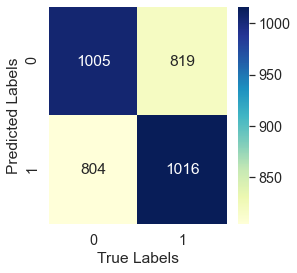

In [39]:
PiplineScore15(DecisionTreeClassifier())

Logistic Regression:

Training Accuracy : 0.5733723153041719
Testing Accuracy : 0.5773874862788145

              precision    recall  f1-score   support

         0.0       0.58      0.58      0.58      1824
         1.0       0.58      0.58      0.58      1820

    accuracy                           0.58      3644
   macro avg       0.58      0.58      0.58      3644
weighted avg       0.58      0.58      0.58      3644



0.5773874862788145

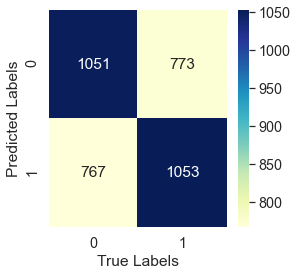

In [40]:
PiplineScore15(LogisticRegression())

KNN Classifier:

Training Accuracy : 0.6717080850106826
Testing Accuracy : 0.6067508232711306

              precision    recall  f1-score   support

         0.0       0.63      0.52      0.57      1824
         1.0       0.59      0.69      0.64      1820

    accuracy                           0.61      3644
   macro avg       0.61      0.61      0.60      3644
weighted avg       0.61      0.61      0.60      3644



0.6067508232711306

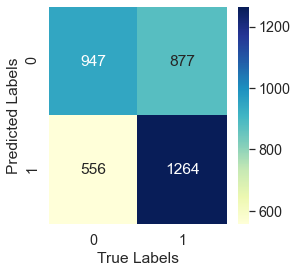

In [41]:
PiplineScore15(KNeighborsClassifier(n_neighbors=15))

Ada Boost Classifier:

Training Accuracy : 0.6185764084111098
Testing Accuracy : 0.6111416026344676

              precision    recall  f1-score   support

         0.0       0.61      0.60      0.61      1824
         1.0       0.61      0.63      0.62      1820

    accuracy                           0.61      3644
   macro avg       0.61      0.61      0.61      3644
weighted avg       0.61      0.61      0.61      3644



0.6111416026344676

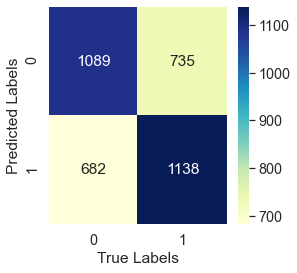

In [42]:
PiplineScore15(AdaBoostClassifier())

XGB Classifier:

[12:02:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.860339592938266
Testing Accuracy : 0.6344676180021954

              precision    recall  f1-score   support

         0.0       0.64      0.61      0.63      1824
         1.0       0.63      0.66      0.64      1820

    accuracy                           0.63      3644
   macro avg       0.63      0.63      0.63      3644
weighted avg       0.63      0.63      0.63      3644



0.6344676180021954

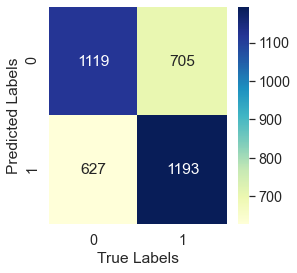

In [43]:
PiplineScore15(XGBClassifier())

Gradient Boosting Classifier:

Training Accuracy : 0.6635556055324412
Testing Accuracy : 0.6300768386388584

              precision    recall  f1-score   support

         0.0       0.65      0.58      0.61      1824
         1.0       0.62      0.68      0.65      1820

    accuracy                           0.63      3644
   macro avg       0.63      0.63      0.63      3644
weighted avg       0.63      0.63      0.63      3644



0.6300768386388584

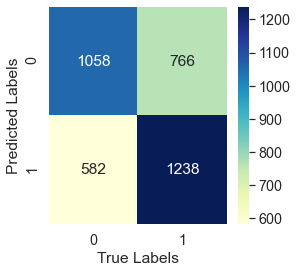

In [44]:
PiplineScore15(GradientBoostingClassifier())

Random Forest Classifier:

Training Accuracy : 1.0
Testing Accuracy : 0.6385839736553238

              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65      1824
         1.0       0.65      0.61      0.63      1820

    accuracy                           0.64      3644
   macro avg       0.64      0.64      0.64      3644
weighted avg       0.64      0.64      0.64      3644



0.6385839736553238

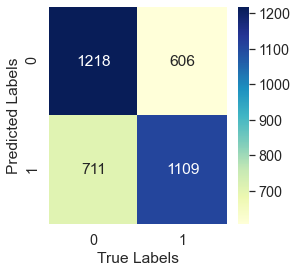

In [45]:
PiplineScore15(RandomForestClassifier())

Bagging Classifier:

Training Accuracy : 0.9928033284605869
Testing Accuracy : 0.6448957189901208

              precision    recall  f1-score   support

         0.0       0.64      0.66      0.65      1824
         1.0       0.65      0.63      0.64      1820

    accuracy                           0.64      3644
   macro avg       0.65      0.64      0.64      3644
weighted avg       0.65      0.64      0.64      3644



0.6448957189901208

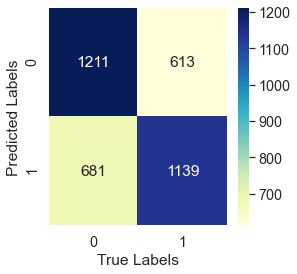

In [46]:
PiplineScore15(BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10, random_state=0))

We got some scores of models that we learned about.<br>
Now we'll try to put the best of them inside Stacking Classifier and Voting Classifier.

### Stacking Classifier

In [47]:
sc=StackingClassifier(estimators=[
                            ("pip1", KNeighborsClassifier(n_neighbors=15)),
                            ("pip2", XGBClassifier()),
                            ("pip3", GradientBoostingClassifier()),
                            ("pip4", RandomForestClassifier()),
                            ("pip5", AdaBoostClassifier()),
                            ("pip6", BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10, random_state=0))
                                ])

[12:07:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:08:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:08:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:08:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.6470911086717892

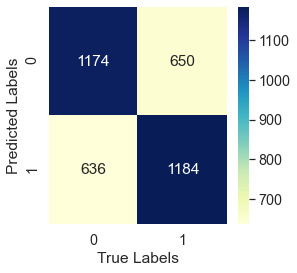

In [48]:
PiplineScore15(sc)

In [49]:
sc2=StackingClassifier(estimators=[
                            ("pip1", BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10, random_state=0)),
                            ("pip2", XGBClassifier()),
                            ("pip3", GradientBoostingClassifier()),
                            ("pip4", RandomForestClassifier())
                                ])

[12:13:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.645993413830955

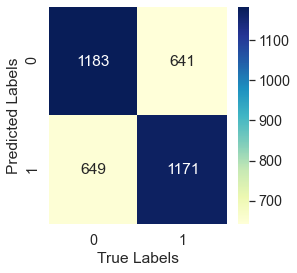

In [50]:
PiplineScore15(sc2)

In [51]:
sc3=StackingClassifier(estimators=[
                            ("pip1", KNeighborsClassifier(n_neighbors=15)),
                            ("pip2", XGBClassifier()),
                            ("pip3", GradientBoostingClassifier()),
                            ("pip4", RandomForestClassifier()),
                            ("pip5", AdaBoostClassifier()),
                            ("pip6", DecisionTreeClassifier()),
                            ("pip7", LogisticRegression()),
                            ("pip8", BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10, random_state=0))
                                ])

[12:18:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.6432491767288694

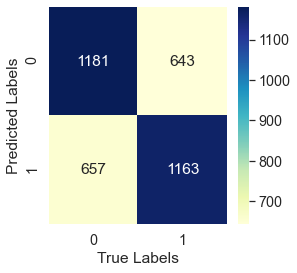

In [52]:
PiplineScore15(sc3)

### Voting Classifier

In [53]:
vc=VotingClassifier(estimators=[
                            ("pip1", KNeighborsClassifier(n_neighbors=15)),
                            ("pip2", XGBClassifier()),
                            ("pip3", GradientBoostingClassifier()),
                            ("pip4", RandomForestClassifier()),
                            ("pip5", AdaBoostClassifier()),
                            ("pip6", BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10, random_state=0))
                                ])

[12:22:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.8666366805352524
Testing Accuracy : 0.6427003293084522

              precision    recall  f1-score   support

         0.0       0.64      0.67      0.65      1824
         1.0       0.65      0.62      0.63      1820

    accuracy                           0.64      3644
   macro avg       0.64      0.64      0.64      3644
weighted avg       0.64      0.64      0.64      3644



0.6427003293084522

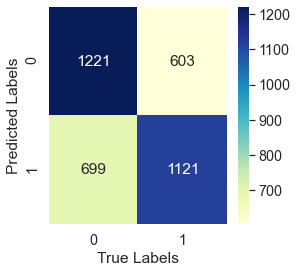

In [54]:
PiplineScore15(vc)

In [55]:
vc2=VotingClassifier(estimators=[
                            ("pip1", BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10, random_state=0)),
                            ("pip2", XGBClassifier()),
                            ("pip3", GradientBoostingClassifier()),
                            ("pip4", RandomForestClassifier())
                                ])

[12:24:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.960305858540425
Testing Accuracy : 0.6399560922063666

              precision    recall  f1-score   support

         0.0       0.63      0.69      0.66      1824
         1.0       0.65      0.59      0.62      1820

    accuracy                           0.64      3644
   macro avg       0.64      0.64      0.64      3644
weighted avg       0.64      0.64      0.64      3644



0.6399560922063666

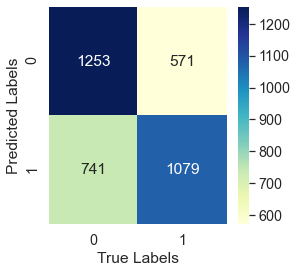

In [56]:
PiplineScore15(vc2)

In [57]:
vc3=VotingClassifier(estimators=[
                            ("pip1", KNeighborsClassifier(n_neighbors=15)),
                            ("pip2", XGBClassifier()),
                            ("pip3", GradientBoostingClassifier()),
                            ("pip4", RandomForestClassifier()),
                            ("pip5", AdaBoostClassifier()),
                            ("pip6", DecisionTreeClassifier()),
                            ("pip7", LogisticRegression()),
                            ("pip8", BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10, random_state=0))
                                ])

[12:26:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.8922748228944113
Testing Accuracy : 0.6385839736553238

              precision    recall  f1-score   support

         0.0       0.63      0.66      0.65      1824
         1.0       0.64      0.62      0.63      1820

    accuracy                           0.64      3644
   macro avg       0.64      0.64      0.64      3644
weighted avg       0.64      0.64      0.64      3644



0.6385839736553238

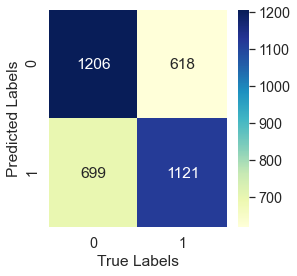

In [58]:
PiplineScore15(vc3)

The best score we got was sc's score.<br>
We'll use this model for our final model.

# Final Model

In [59]:
finalX_train = FinalTrain.drop(['label'],axis=1)
finalY_train = FinalTrain.label
finalX_test = FinalTest.drop(['label'],axis=1)
finalY_test = FinalTest.label

In [66]:
def PiplineScore15Final():
    pipeline_model = Pipeline([('scaler', StandardScaler()),
                               ('pca' , PCA(n_components=15)),
                               ('model' , StackingClassifier(estimators=[
                                                                ("pip1", KNeighborsClassifier(n_neighbors=15)),
                                                                ("pip2", XGBClassifier()),
                                                                ("pip3", GradientBoostingClassifier()),
                                                                ("pip4", RandomForestClassifier()),
                                                                ("pip5", AdaBoostClassifier()),
                                                                ("pip6", BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=10, random_state=0))
                                                                        ]))])
    
    pipeline_model.fit(finalX_train , finalY_train)
    #model prediction
    y_pred = pipeline_model.predict(finalX_test)
    sns.set(font_scale=1.3)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax = sns.heatmap(confusion_matrix(finalY_test, y_pred), annot=True, cbar=True , cmap="BuPu" , fmt = '.0f')
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    # evaluating the model
    print("Training Accuracy :", pipeline_model.score(finalX_train, finalY_train))
    print("Testing Accuracy :" , metrics.accuracy_score(finalY_test, y_pred))
    print()
    print(classification_report(finalY_test, y_pred))
    return pipeline_model.score(finalX_test , finalY_test)

[13:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:03:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

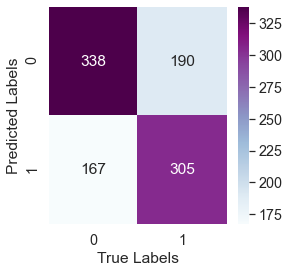

In [84]:
score = PiplineScore15Final()

In [89]:
print('Final Model Score : ' , score*100 , '%')

Final Model Score :  64.3 %


# Final Score

The model finished with the score of 64.3% while it uses only 15 features.